# Group Analysis - FOOOFed EEG Analysis

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from os import listdir
from os.path import join as pjoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, sem, pearsonr

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_group
from fooof.core.funcs import gaussian_function
from fooof.core.funcs import expo_nk_function

from om.core.utils import clean_file_list

In [3]:
# Import custom code for this analysis
% autoreload 2
from plts import *

### Settings

In [4]:
# Set which group to run
group = 'G2'

# Set path to load results from
res_path = pjoin('/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/', group)

# Data settings
srate = 512
tmin, tmax = -0.85, 1.1
n_times = 3
n_loads = 3
n_subjs = 31

# Set indices to separate groups
yng_inds = range(14, 31)
old_inds = range(0, 14)

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

print('Number of young subjects:  ', len(yng_inds))
print('Number of  old  subjects:  ', len(old_inds))

Number of young subjects:   17
Number of  old  subjects:   14


### Helper Functions

In [5]:
def drop_nan(vec):
    return vec[~np.isnan(vec)]

def print_stat(label, stat_val, p_val):
    print(label + ': \t {: 5.4f} \t{:5.4f}'.format(stat_val, p_val))

## Behavioural Data

In [6]:
# Load behavioural Data
behav_file = pjoin(res_path, 'Behav', 'neural_aging_data_behaviour.csv')
behav_dat = pd.read_csv(behav_file)

In [7]:
# Sanity check behavioural data
behav_dat.head()

,SubjID,Age,Load,CDA,d'
0,1,1,1,-0.442318,4.701454
1,2,1,1,-0.326298,3.934543
2,3,1,1,-1.291108,3.040111
3,4,1,1,-1.692917,4.733815
4,5,1,1,-0.173045,4.380097


In [8]:
# Collapse behavioural data across loads
avg_behav = behav_dat.groupby('SubjID').mean()

In [50]:
# Check correlations between d' and CDA measure
print_stat('All: \t', *pearsonr(avg_behav["CDA"], avg_behav["d'"]))
print_stat('Yng: \t', *pearsonr(avg_behav[avg_behav['Age'] == 1]["CDA"], avg_behav[avg_behav['Age'] == 1]["d'"]))
print_stat('Old: \t', *pearsonr(avg_behav[avg_behav['Age'] == 2]["CDA"], avg_behav[avg_behav['Age'] == 2]["d'"]))

All: 	: 	  0.0104 	0.9555
Yng: 	: 	  0.2805 	0.2755
Old: 	: 	 -0.4481 	0.1081


### Alpha Peak Frequency

In [10]:
# Load alpha peaks
#alpha_freqs = np.load(pjoin(res_path, 'Group', 'alpha_freqs_group.npy'))

# Check average alpha frequency per group
#print(avg_func(alpha_freqs[yng_inds]))
#print(avg_func(alpha_freqs[old_inds]))

### Check dropped trials

In [11]:
# Load dropped trials & components
dropped_trials = np.load(pjoin(res_path, 'Group', 'dropped_trials.npy'))
dropped_components = np.load(pjoin(res_path, 'Group', 'dropped_components.npy'))

# Check dropped trials for each subject
print('SubNum \t\t # Dropped Trials \t # Dropped Components')
for ind, trials, components in zip(range(n_subjs), dropped_trials, dropped_components):
    temp_trials = trials[np.nonzero(trials)]
    temp_comps = components[np.nonzero(components)]
    print(ind, '\t\t', len(temp_trials), '\t\t\t', len(temp_comps))

SubNum 		 # Dropped Trials 	 # Dropped Components
0 		 0 			 0
1 		 0 			 0
2 		 0 			 0
3 		 0 			 0
4 		 0 			 0
5 		 0 			 0
6 		 0 			 0
7 		 0 			 0
8 		 0 			 0
9 		 0 			 0
10 		 0 			 0
11 		 0 			 0
12 		 0 			 0
13 		 0 			 0
14 		 0 			 0
15 		 0 			 0
16 		 0 			 0
17 		 0 			 0
18 		 0 			 0
19 		 0 			 0
20 		 0 			 0
21 		 0 			 0
22 		 0 			 0
23 		 0 			 0
24 		 0 			 0
25 		 0 			 0
26 		 0 			 0
27 		 0 			 0
28 		 0 			 0
29 		 0 			 0
30 		 0 			 0


### Task Related - Filtered Alpha Response

In [12]:
# Load data
canonical_group = np.load(pjoin(res_path, 'Group', 'canonical_group.npy'))
fooofed_group = np.load(pjoin(res_path, 'Group', 'fooofed_group.npy'))

In [13]:
# Partition group
subset = 'young' # 'young', 'old', 'all'
if subset == 'old':
    canonical_group = canonical_group[0:15, :, :]
    fooofed_group = fooofed_group[0:15, :, :]
if subset == 'young':
    canonical_group = canonical_group[15:, :, :]
    fooofed_group = fooofed_group[15:, :, :]
if subset == 'all':
    canonical_group = canonical_group
    fooofed_group = fooofed_group

In [14]:
# Average across subjects
canonical_group_avg = avg_func(canonical_group, 0)
fooofed_group_avg = avg_func(fooofed_group, 0)

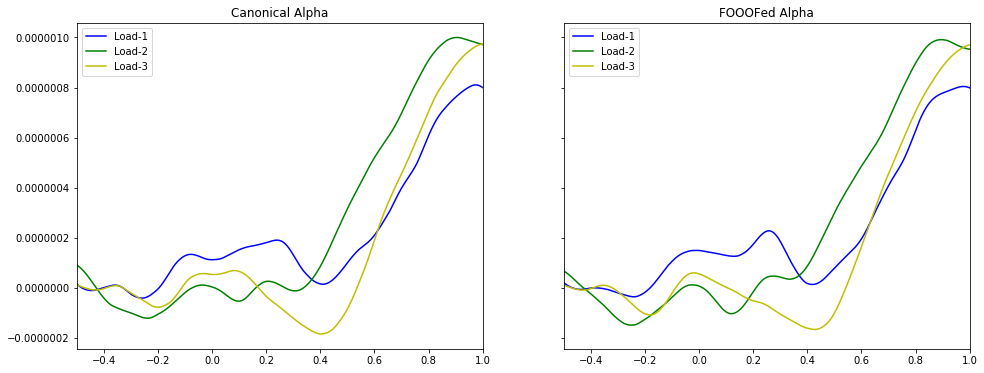

In [15]:
# Plot the alpha response - group average
plot_alpha_response_compare(canonical_group_avg, fooofed_group_avg, [tmin, tmax], srate)

In [16]:
# Plot each individual subject
#for alpha_subj, fooof_subj in zip(canonical_group, fooofed_group):
#    plot_alpha_response_compare(alpha_subj, fooof_subj, [tmin, tmax], srate)

In [17]:
# Grab the time that represent the late time period: 0.8 - 1.0
times = np.arange(tmin, tmax, 1/srate)
late_times = np.array(times >= 0.8) & np.array(times <= 1.0)

In [18]:
# Extract late time period, and average across it
#canonical_group_late = np.mean(canonical_group[:, :, late_times], 2)
#fooofed_group_late = np.mean(fooofed_group[:, :, late_times], 2)

canonical_group_late = np.median(canonical_group[:, :, late_times], 2)
fooofed_group_late = np.median(fooofed_group[:, :, late_times], 2)

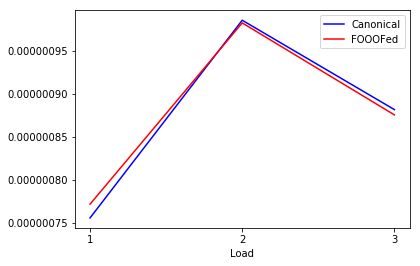

In [19]:
# Plot group average alpha power, per load, in late window, for canonical & fooofed bands
plt.figure()
plt.plot(avg_func(canonical_group_late, 0), 'b', label='Canonical')
plt.plot(avg_func(fooofed_group_late, 0), 'r', label='FOOOFed')
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.xlabel('Load')
plt.legend();

In [20]:
# # ??
# plt.figure()
# plt.errorbar([0, 1, 2], np.median(canonical_group_late, 0), sem(canonical_group_late))
# plt.errorbar([0, 1, 2], np.median(fooofed_group_late, 0), sem(fooofed_group_late))
# plt.xticks([0, 1, 2], [1, 2, 3]);
# plt.xlabel('Load')

In [21]:
canonical_group_late

array([[  8.55953734e-07,   1.22794265e-06,   9.13771004e-07],
       [  9.38705725e-07,   1.02152064e-06,   8.53309548e-07],
       [  3.79297956e-07,   2.46072944e-07,   1.53527292e-06],
       [  1.48723063e-07,  -1.56438084e-07,   3.25470934e-07],
       [ -5.29902545e-07,  -3.23444926e-07,  -4.23461354e-07],
       [  1.72594066e-06,   2.67960077e-06,   1.65561258e-06],
       [ -3.56587034e-08,   1.30126531e-07,   6.92612357e-08],
       [ -4.35918477e-07,  -4.73382840e-07,  -4.71984368e-07],
       [  7.83012930e-07,   1.22052031e-06,   3.69395999e-07],
       [  3.50738951e-06,   6.66020557e-06,   5.16815102e-06],
       [  1.09159091e-07,   1.52037922e-08,   1.96263068e-07],
       [  1.09979474e-07,   2.06215048e-07,   3.90527201e-07],
       [ -1.34828758e-06,  -1.09933149e-06,  -1.97686085e-06],
       [ -1.76168511e-07,   6.87743066e-07,   4.22332784e-07],
       [  1.03474746e-06,   2.62212870e-07,  -8.27456878e-08],
       [  5.02939157e-06,   3.45731753e-06,   5.1605800

In [22]:
# print(stats.f_oneway(*canonical_group_late))
# print(stats.f_oneway(*fooofed_group_late))

In [23]:
# dat = np.array([[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [3, 3, 3, 3, 3]])
# stats.f_oneway(*dat)

In [24]:
#import statsmodels.api as sm
#table = sm.stats.anova_lm(moore_lm, typ=2)
#stats.f_oneway(canonical_group_late)

In [25]:
#avg_behav

In [26]:
#alphas

## FOOOF

In [27]:
# Settings
save_fig = False

In [28]:
# Get list of all FOOOF files
files = listdir(pjoin(res_path, 'FOOOF'))

# Select group files
files = clean_file_list(files, 'RAW')

#Check file names
#print(files)

In [29]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(res_path, 'FOOOF'))
    fgs.append(fg.copy())

In [30]:
# Grab alphas from each subject
ch_ind = 28  # 28 is Oz
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    #alphas[ind, :] = get_band_peak_group(fg.get_all_data('gaussian_params'), [7, 14], len(fg))[ch_ind, :]
    alphas[ind, :] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[ch_ind, :]

In [91]:
# Grab background slope from each subject
ch_ind = 47 # 47 is Cz
bgs = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    bgs[ind, :] = fg.get_all_data('background_params')[ch_ind]
offs = bgs[:, 0]
sls = bgs[:, 1]

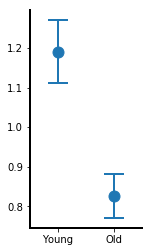

In [92]:
# Plot slope comparison
plot_comp(sls, save_fig=save_fig, save_name='Slopes')

In [93]:
# Statistically test slope difference
print_stat('Slope t-test', *ttest_ind(sls[yng_inds], sls[old_inds]))
print('Mean Difference: \t', np.mean(sls[yng_inds]) - np.mean(sls[old_inds]))

Slope t-test: 	  3.5996 	0.0012
Mean Difference: 	 0.363850623814


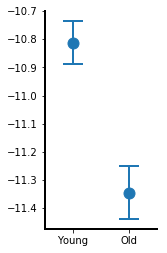

In [94]:
# Plot offset comparison
plot_comp(offs, save_fig=save_fig, save_name='Offset')

In [95]:
# Statistically test offset difference
print_stat('Offset t-test', *ttest_ind(offs[yng_inds], offs[old_inds]))
print('Mean Difference: \t', np.mean(offs[yng_inds]) - np.mean(offs[old_inds]))

Offset t-test: 	  4.4656 	0.0001
Mean Difference: 	 0.532262498321


### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the background + the alpha peak amplitude.

In [36]:
# Set the channel to extract alpha power from
ch_ind = 28 # Oz

# Collect the background parameters for each subject
oz_bgs = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_bgs[ind, :] = fg.get_all_data('background_params')[ch_ind]

# Calculate total alpha as the value of the BG function at alpha CF, please the amplitude of the alpha peak
tot_alphas = []
for bg, cf, amp in zip(oz_bgs, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the background at CF of 10, and set alpha amplitude to zero
    if np.isnan(cf):
        cf, amp = 10, 0
    
    # Calculate the value of the background function at the alpha-CF, and add the alpha-amp
    tot_alphas.append(expo_nk_function(np.array([cf]), *bg)[0] + amp)
    
tot_alphas = np.array(tot_alphas)

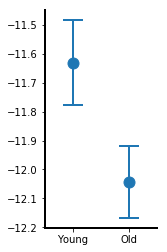

In [37]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp(tot_alphas, save_fig=save_fig, save_name='TotalAlpha')

In [38]:
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[yng_inds], tot_alphas[old_inds]))
print('Mean Difference: \t', np.mean(tot_alphas[yng_inds]) - np.mean(tot_alphas[old_inds]))

Total Alpha t-test: 	  2.1005 	0.0445
Mean Difference: 	 0.4126073973


### Check number of extracted oscillations

In [39]:
ch_ind = 28  # Oz
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [40]:
print('# Oscs Yng:', np.mean(n_oscs[yng_inds]))
print('# Oscs Old:', np.mean(n_oscs[old_inds]))
print_stat('\n# Oscs Diff', *ttest_ind(n_oscs[yng_inds], n_oscs[old_inds]))

# Oscs Yng: 3.58823529412
# Oscs Old: 3.92857142857

# Oscs Diff: 	 -0.6500 	0.5208


### Statistically Compare Peak Parameters

In [41]:
for d_ind, label in zip([0, 1, 2], ['CF', 'Amp', 'BW']):

    # Select data
    dat = alphas[:, d_ind]
    you_dat = list(dat[yng_inds][~np.isnan(dat[yng_inds])])# + [0] * sum(np.isnan(dat[yng_inds]))
    old_dat = list(dat[old_inds][~np.isnan(dat[old_inds])])# + [0] * sum(np.isnan(dat[old_inds]))
    
    # Statistically compare and check average difference between groups
    print(label)
    #print('\t', ttest_ind(you_dat, old_dat))
    print_stat('\tDiff', *ttest_ind(you_dat, old_dat))
    print('\tMean Diff: ', np.mean(you_dat - np.mean(old_dat)))
    
# Check how many subjects, 
print('\nNumber of subjects with no alpha:')
print('\t Young:\t', sum(np.isnan(dat[yng_inds])))
print('\t Old: \t', sum(np.isnan(dat[old_inds])))

CF
	Diff: 	  2.3891 	0.0236
	Mean Diff:  1.08162107598
Amp
	Diff: 	  2.0760 	0.0469
	Mean Diff:  0.326440560768
BW
	Diff: 	  0.4308 	0.6698
	Mean Diff:  0.138086208083

Number of subjects with no alpha:
	 Young:	 0
	 Old: 	 0


### Alpha - Center Frequency

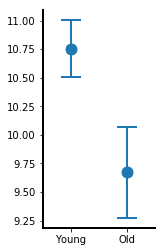

In [42]:
plot_comp(alphas[:, 0], save_fig=save_fig, save_name='AlphaCF')

### Alpha - Amplitude

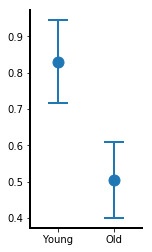

In [43]:
plot_comp(alphas[:, 1], save_fig=save_fig, save_name='AlphaAmp')

### Alpha - Bandwidth

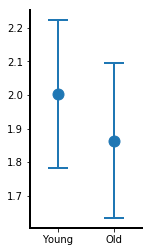

In [44]:
plot_comp(alphas[:, 2], save_fig=save_fig, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

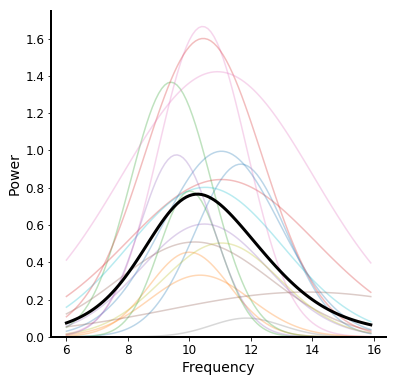

In [45]:
plot_oscillations(alphas[yng_inds, :], save_fig=save_fig, save_name='YoungAlphas')

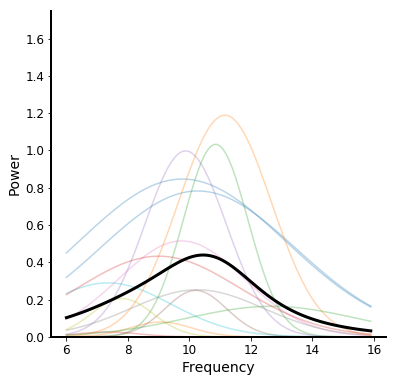

In [46]:
plot_oscillations(alphas[old_inds, :], save_fig=save_fig, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band

Note that the approach to do this is taken from:

https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy

Note: approach below 

In [53]:
from scipy.stats import norm

def get_intersect(m1, m2, std1, std2):
    """Gets the point of intersection of two gaussians defined by (m1, std1) & (m2, std2)"""
    a = 1./(2.*std1**2) - 1./(2.*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])[0]

def get_overlap(intersect, m1, m2, std1, std2):
    """Get the percent overlap of two gaussians, given their definitions, and intersection point."""
    return norm.cdf(intersect, m2, std2) + (1. - norm.cdf(intersect, m1, std1))

In [54]:
overlaps = []
mean, std = 10, 2

for alpha in alphas:
    ind_mean, ind_std = alpha[0], 2#alpha[2]
    
    if ind_mean < mean:
        m1, std1, m2, std2 = ind_mean, ind_std, mean, std
    else:
        m1, std1, m2, std2 = mean, std, ind_mean, ind_std
        
    intersect = get_intersect(m1, m2, std1, std2)
    overlaps.append(get_overlap(intersect, m1, m2, std1, std2))
    
overlaps = np.array(overlaps)

In [55]:
# Check average (overall) of overlaps
np.mean(overlaps)

0.8138910204482841

In [56]:
# Check average per yng & old group, and test difference
print(np.mean(overlaps[yng_inds]))
print(np.mean(overlaps[old_inds]))

print_stat('\nDiff Overlap:', *ttest_ind(overlaps[yng_inds], overlaps[old_inds]))

0.833650849207
0.78989694267

Diff Overlap:: 	  0.6986 	0.4904


#### Plot Overlap

Plot for an example case, using the average deviation from 10 Hz. 

In [57]:
# Get the average deviation from center of 10 Hz
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

0.806999881209


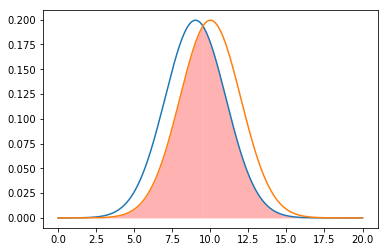

In [58]:
m1, m2, std1, std2 = 10-avg_deviation, 10, 2, 2
r = get_intersect(m1, m2, std1, std2)
print(get_overlap(r, m1, m2, std1, std2))

#Get point on surface
plt.figure()
x = np.linspace(0,20,10000)
plot1 = plt.plot(x, norm.pdf(x, m1, std1))
plot2 = plt.plot(x, norm.pdf(x, m2, std2))
plot3 = plt.plot(r, norm.pdf(r, m1, std1))#, 'o')

#Plots integrated area
olap = plt.fill_between(x[x>r], 0, norm.pdf(x[x>r], m1, std1), alpha=0.3, color='r', lw=0)
olap = plt.fill_between(x[x<r], 0, norm.pdf(x[x<r], m2, std2), alpha=0.3, color='r', lw=0)

#### Compare Slopes

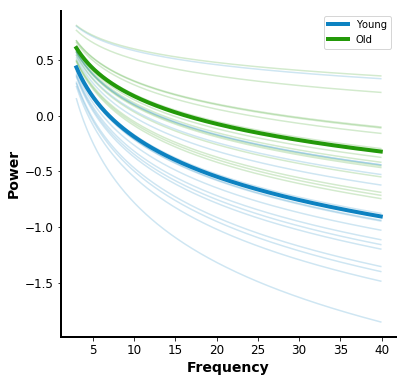

In [59]:
plot_background(bgs, save_fig=save_fig, save_name='Backgrounds')

### Compare 'Peaks' from Background

Question: compare with just slope, or with slope & offset?

In [60]:
# Pull out the difference in power, at 10 Hz, arising from BG difference
sl_alphas = []
for bg in bgs:
    sl_alphas.append(expo_nk_function(np.array([10]), *bg)[0])
sl_alphas = np.array(sl_alphas)

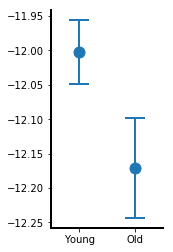

In [61]:
#
plot_comp(sl_alphas, save_fig=save_fig, save_name='BGAlpha')

In [62]:
# Statistically test difference in 'BG-Alpha'
ttest_ind(sl_alphas[yng_inds], sl_alphas[old_inds])

Ttest_indResult(statistic=2.0245392118056609, pvalue=0.052210657699723134)

In [63]:
#
freqs = range(2, 42, 2)
model_bgs = []
for bg in bgs:
    model_bgs.append(expo_nk_function(np.array(freqs), *bg))#[0])
model_bgs = np.array(model_bgs)

In [64]:
n_freqs = len(freqs)

In [65]:
n_freqs

20

In [66]:
model_bgs.shape

(31, 20)

In [67]:
np.mean(model_bgs)

-12.304716003968187

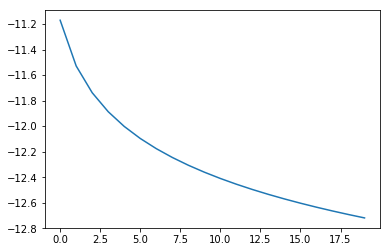

In [68]:
plt.plot(np.mean(model_bgs[yng_inds, :], 0))

In [69]:
for aa in model_bgs.T:
    #print(aa)
    #plot_comp(aa)
    print(np.mean(aa[yng_inds] - np.mean(aa[old_inds])))
    print(ttest_ind(aa[yng_inds], aa[old_inds]))
#    print(aa.shape)

0.422732546612
Ttest_indResult(statistic=4.2565352083731423, pvalue=0.00019855559249869559)
0.313202594903
Ttest_indResult(statistic=3.6479129869462406, pvalue=0.001031038249050963)
0.249131680447
Ttest_indResult(statistic=3.0272875712228671, pvalue=0.0051366174031186734)
0.203672643194
Ttest_indResult(statistic=2.4823823489780064, pvalue=0.019085461616329003)
0.168411874507
Ttest_indResult(statistic=2.0245392118056609, pvalue=0.052210657699723134)
0.139601728738
Ttest_indResult(statistic=1.6434091945870632, pvalue=0.11109829626025715)
0.115243097569
Ttest_indResult(statistic=1.3248783931886379, pvalue=0.19555689652820421)
0.0941426914849
Ttest_indResult(statistic=1.0562720906741521, pvalue=0.29956429489850045)
0.0755308142827
Ttest_indResult(statistic=0.82738139286415613, pvalue=0.41477764552307994)
0.0588819227981
Ttest_indResult(statistic=0.63027223144440991, pvalue=0.5334518829664181)
0.0438211684819
Ttest_indResult(statistic=0.45883421596928181, pvalue=0.64977372235661157)
0.03007

In [ ]:
#modelold_inds

In [ ]:
model_bgs.shape

In [ ]:
len(range(3, 40))

In [ ]:
t_alphas = np.copy(alphas)
t_alphas[3, :] = [10, 0, 0]

In [ ]:
ch_ind = 28  # Oz
errs = []
r2s = []
for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)
errs = np.array(errs)
r2s = np.array(r2s)

In [ ]:
plot_comp(errs)

In [ ]:
print(ttest_ind(r2s[yng_inds], r2s[old_inds]))
print(ttest_ind(errs[yng_inds], errs[old_inds]))

In [ ]:
oz_offs = oz_bgs[:, 0]
oz_sls = oz_bgs[:, 1]

In [ ]:
print(pearsonr(offs, sls))
print(pearsonr(oz_offs, oz_sls))

In [ ]:
# Correlations between oscillation features
print(pearsonr(t_alphas[:, 0], t_alphas[:, 1]))
print(pearsonr(t_alphas[:, 0], t_alphas[:, 2]))
print(pearsonr(t_alphas[:, 1], t_alphas[:, 2]))

In [ ]:
# Correlations between slope and oscillation features
print(pearsonr(t_alphas[:, 0], oz_sls))
print(pearsonr(t_alphas[:, 1], oz_sls))
print(pearsonr(t_alphas[:, 2], oz_sls))

In [ ]:
# Oz alpha with Cz Slope (?)
print(pearsonr(t_alphas[:, 1], sls))

In [ ]:
print(pearsonr(errs, r2s))

In [ ]:
# Correlation between FOOOF outputs and error
print(pearsonr(errs, t_alphas[:, 0]))
print(pearsonr(errs, t_alphas[:, 1]))
print(pearsonr(errs, t_alphas[:, 2]))
print(pearsonr(errs, oz_sls))

In [ ]:
# Correlation between FOOOF outputs and r2s
print(pearsonr(r2s, t_alphas[:, 0]))
print(pearsonr(r2s, t_alphas[:, 1]))
print(pearsonr(r2s, t_alphas[:, 2]))
print(pearsonr(r2s, oz_sls))

In [ ]:
plt.scatter(errs, t_alphas[:, 1])

In [ ]:
r2s[0]

In [ ]:
np.argmin(r2s)

In [ ]:
#i1, i2 = 0, 1
#i1, i2 = 0, 2
#i1, i2 = 1, 2

# d1 = alphas[:, i1][~np.isnan(alphas[:, i1])]
# d2 = alphas[:, i2][~np.isnan(alphas[:, i2])]
# pearsonr(d1, d2)

## Behavioural Correlations With Baseline FOOOF Measures

#### Correlation of Slope With Behaviour

In [96]:
behav_meas = "d'"
#behav_meas = "CDA"
for meas, label in zip([offs, sls, alphas[:, 0], alphas[:, 1], alphas[:, 2]],
                       ['Offset', 'Slope', 'CF', 'Amp', 'BW']):
    
    print('\n'+label)
    print_stat('\tAll', *pearsonr(avg_behav[behav_meas], np.hstack([meas[yng_inds], meas[old_inds]])))
    print_stat('\tYng', *pearsonr(avg_behav[avg_behav['Age'] == 1][behav_meas], meas[yng_inds]))
    print_stat('\tOld', *pearsonr(avg_behav[avg_behav['Age'] == 2][behav_meas], meas[old_inds]))


Offset
	All: 	  0.1926 	0.2993
	Yng: 	 -0.4826 	0.0497
	Old: 	  0.3720 	0.1902

Slope
	All: 	  0.1606 	0.3880
	Yng: 	 -0.3151 	0.2179
	Old: 	  0.4023 	0.1539

CF
	All: 	  0.1878 	0.3117
	Yng: 	  0.0050 	0.9848
	Old: 	  0.0846 	0.7736

Amp
	All: 	  0.1516 	0.4156
	Yng: 	 -0.2161 	0.4049
	Old: 	  0.3432 	0.2296

BW
	All: 	 -0.1661 	0.3718
	Yng: 	 -0.2984 	0.2446
	Old: 	 -0.1084 	0.7123


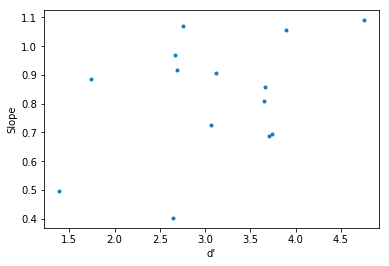

In [72]:
# Plot the correlation between slope and d', in old group
plt.plot(avg_behav[avg_behav['Age'] == 2]["d'"], sls[old_inds], '.')
plt.xlabel("d'")
plt.ylabel("Slope")

In [73]:
print(pearsonr(avg_behav["CDA"], np.hstack([sls[yng_inds], sls[old_inds]])))
print(pearsonr(avg_behav["d'"],  np.hstack([sls[yng_inds], sls[old_inds]])))

(-0.20849627586933789, 0.26034398198323377)
(0.1606410721300541, 0.3879819716979751)


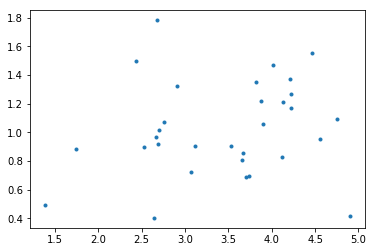

In [74]:
plt.plot(avg_behav["d'"], np.hstack([sls[yng_inds], sls[old_inds]]), '.')

## Group FOOOFing - Trial Averaged Data

- Ipsi & Contra

In [97]:
# Settings
#avg_func = np.nanmean
avg_func = np.nanmedian

In [98]:
#
all_slopes = np.zeros(shape=[n_loads, n_subjs, n_times])
all_alphas = np.zeros(shape=[n_loads, n_subjs, n_times])

#side = 'Contra'
side = 'Ipsi'

for li, load in enumerate(['Load1', 'Load2', 'Load3']):
    
    # Load the FOOOF analyses of the average
    pre, early, late = FOOOFGroup(), FOOOFGroup(), FOOOFGroup()
    pre.load('Group_' + load + '_' + side + '_Pre', pjoin(res_path, 'FOOOF'))
    early.load('Group_' + load + '_' + side +  '_Early', pjoin(res_path, 'FOOOF'))
    late.load('Group_' + load + '_' + side + '_Late', pjoin(res_path, 'FOOOF'))

    for ind, fg in enumerate([pre, early, late]):
        all_slopes[li, :, ind] = fg.get_all_data('background_params', 'slope').T
        all_alphas[li, :, ind] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[:, 1]

In [99]:
# Partition group
subset = 'all'

if subset == 'old':
    all_slopes = all_slopes[:, 0:15, :]
    all_alphas = all_alphas[:, 0:15, :]
if subset == 'young':
    all_slopes = all_slopes[:, 15:, :]
    all_alphas = all_alphas[:, 15:, :]
if subset == 'all':
    all_slopes = all_slopes
    all_alphas = all_alphas

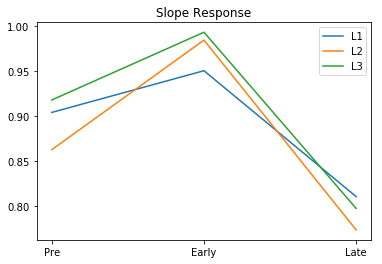

In [100]:
# Plot slope average response - split up by load
plt.figure()
for ii in range(3):
    plt.plot(avg_func(all_slopes[ii, :, :], 0), label='L' + str(ii + 1))
plt.title('Slope Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.legend();

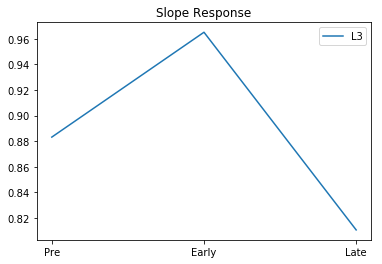

In [101]:
# Plot slope average response - collapsed across loads
plt.figure()
plt.plot(avg_func(avg_func(all_slopes[:, :, :], 0), 0), label='L' + str(ii + 1))
plt.title('Slope Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.legend();

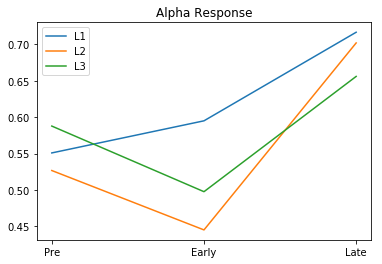

In [102]:
# Plot alpha average response - split up by load
plt.figure()
for ii in range(3):
    plt.plot(avg_func(all_alphas[ii, :, :], 0), label='L' + str(ii + 1))
plt.title('Alpha Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.legend();

/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


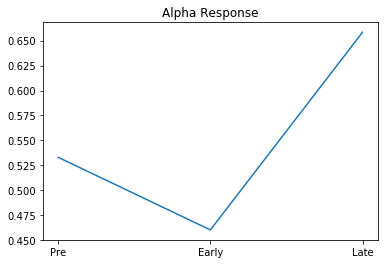

In [103]:
# Plot alpha average response - collapsed across loads
plt.figure()
plt.plot(avg_func(avg_func(all_alphas, 0), 0))
plt.title('Alpha Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);

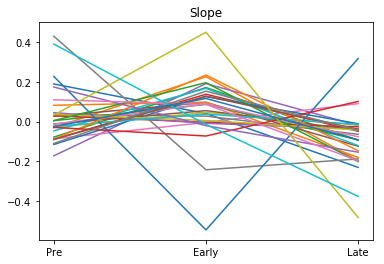

In [104]:
plt.figure()
for dat in all_slopes[2, :, :]:
    #plt.plot(dat)
    plt.plot(dat - np.mean(dat))
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.title('Slope');

In [105]:
# Check the correlation between alpha & slope responses
all_alphas[np.isnan(all_alphas)] = 0
pearsonr(all_alphas[0, :, 1] - all_alphas[0, :, 0], all_slopes[0, :, 1] - all_slopes[0, :, 0])

(-0.37500706630262315, 0.037645497397671514)

In [ ]:
# plt.boxplot([pre.get_all_data('background_params', 'slope'), 
#              early.get_all_data('background_params', 'slope'),
#              late.get_all_data('background_params', 'slope')]);
# plt.xticks([1, 2, 3], ['Pre', 'Early', 'Late']);